In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [252]:
def dyn_gen(B):
    A = torch.tensor([[0,1.0,0],[0,0,1.0],[0,0,0]])
#     A = torch.tensor([[0,1.0],[0,0]])
    B = torch.tensor(B) 
    
    def dynamics(x,u):
        return A @ x + B * u 
    
    return dynamics

# dyn_vel = dyn_gen([[1.0],[0.0]])
# dyn_acc = dyn_gen([[0.0],[1.0]])

dyn_vel = dyn_gen([[1.0],[0.0],[0.0]])
dyn_acc = dyn_gen([[0.0],[1.0],[0.0]])
dyn_jerk = dyn_gen([[0.0],[0.0],[1.0]])


def cost_sq(x,u):
    pos = x if x.numel()==1 else x[0]
    return pos**2/10 +  u**2     

def cost(x,u):
    pos = x if x.numel()==1 else x[0]
    return 1 - (-pos**2).exp() +  u**2 #+ (pos**2 + 0*pos.abs())/1000      


def simulate(x0, u_all, dyn, iter_large):
    l = 0.0
    x = x0
    x_all = []
    x_all.append(x.detach().view(-1).numpy())
    for u in u_all:
        x = x + dyn(x, u)
        l = l + cost(x,u) if iter_large else  l + cost_sq(x,u)
        x_all.append(x.detach().view(-1).numpy())
    return l, x_all 


def optimize_u(x0, T, dyn, epoch, lr):
    l_all, u_all  = [], []
#     x0 = torch.tensor([x0, 0.0]).view(2,1) 
    x0 = torch.tensor([x0, 0.0, 0.0]).view(3,1) 
#     u = torch.rand(T, requires_grad=True)
    u = torch.zeros(T, requires_grad=True)
#     u = -0.4*torch.ones(T); u.requires_grad=True
    optim = torch.optim.SGD([u], lr=lr, momentum = 0.9)    #  optim = torch.optim.Adam([u], lr=lr)
    
    for iter_ in range(epoch):
        optim.zero_grad()
        l, x = simulate(x0, u, dyn, iter_>epoch/5)
        l.backward()
        optim.step()
        l_all.append(l.item())
        u_all.append(u.clone().detach().numpy())

    return l_all, x, u_all, u.detach()
    


In [265]:
def plot_all(l_all, u_opt, x_opt):
    plt.figure()
    plt.subplot(1, 2, 1)

    plt.semilogy(l_all)
    plt.legend(['loss'])
    
    plt.subplot(1, 2, 2)
    plt.plot(u_opt*-10)
    plt.plot(x_opt)
    plt.legend(['control', 'position', 'velocity', 'acceleration'])
    plt.show()


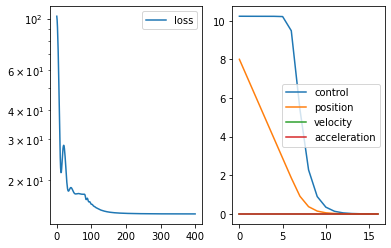

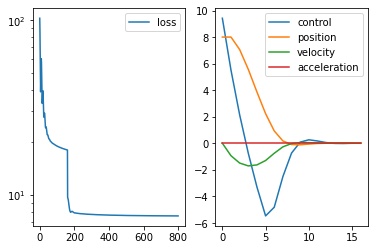

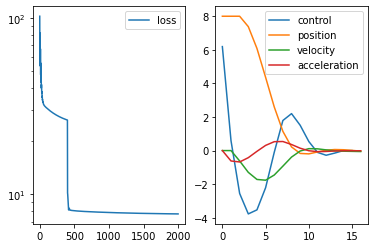

In [267]:

T= 16 #8
l_all, x_opt, u_all, u_opt = optimize_u(8.0, T, dyn_vel, epoch = 400, lr = 0.001)
plot_all(l_all, u_opt, x_opt)
    
l_all, x_opt, u_all, u_opt = optimize_u(8.0, T, dyn_acc, epoch = 800, lr = 0.0001)
plot_all(l_all, u_opt, x_opt)

l_all, x_opt, u_all, u_opt = optimize_u(8.0, T, dyn_jerk, epoch = 2000, lr = 0.000015)
plot_all(l_all, u_opt, x_opt)
